<a href="https://colab.research.google.com/github/MarkusStefan/Data_Analytics/blob/main/Exercise3/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import torch

from sklearn.cluster import KMeans


In [2]:
arrests = pd.read_csv('https://raw.githubusercontent.com/MarkusStefan/Data_Analytics/main/Exercise3/USArrests.csv')
arrests.index = arrests.iloc[:, 0]
arrests = arrests.iloc[:, 1:len(arrests.columns)]
arrests.index.name = None
arrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
arrests.describe().T # Transposed

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


## Standardization
+ Since we are only interested in variance it is recommended to rescale each feature vector
\begin{equation*}
x_{ij}'=\frac{x_{ij}-\mu_i}{\sigma_i}
\end{equation*}
where 
    - $x_{ji}$ is an observed value, 
    - $\mu_i$ is the mean of the population, can be estimated using the average $\overline{x}_i$ of all values observed for the feature $i$
    - $\sigma_i$ is the standard deviation of the population, can be estimated as $$S_i=\sqrt{\frac{1}{n-1}\sum{(x_{ji}-\overline{x}_i})^2}$$
    
+ Replacement of feature values with standard scores $x_{ij}'$ is called *standartization* and is recommended for many ML algorithms
+ The matrix of standard scores 
  - is *centered* - subtraction of the mean of every column from its values, and
  - has *unit standard deviation* - division by the standard deviation of the data in this column

In [30]:
import pandas as pd

def standardize(df):
  d = {}
  for j in df.columns:
    mu = df[j].mean()
    sigma = df[j].std()
    x = (df[j] - mu) / sigma
    d[j] = x
  return pd.DataFrame(d)


arrests = standardize(arrests)
arrests.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,-2.220446e-17,1.0,-1.604405,-0.852483,-0.123522,0.794855,2.206860
Assault,50.0,-1.554312e-17,1.0,-1.509042,-0.741082,-0.141113,0.938831,1.994776
UrbanPop,50.0,1.221245e-17,1.0,-2.317136,-0.762707,0.031779,0.843537,1.758923
Rape,50.0,2.220446e-18,1.0,-1.487447,-0.657351,-0.120858,0.527738,2.644350


# Hierarchical (Agglomerative) Clustering [bottom-up approach]

## Idea behind Hierarchical clustering

+ Hierarchical clustering is an approach which does not require any parameters
+ Can be of two types: bottom-up or agglomerative as well as top-down or divisive
+ Here we consider the agglomerative variant, which is the most common type of hierarchical clustering
+ Dendrogram is built starting from the leaves and combining clusters up to the trunk

## Agglomerative clustering

####Algorithm:

1. Start with each point in its own cluster
2. Identify the closest two clusters wrt. within-cluster variation measure and merge them 
3. Repeat until all points are in a single cluster

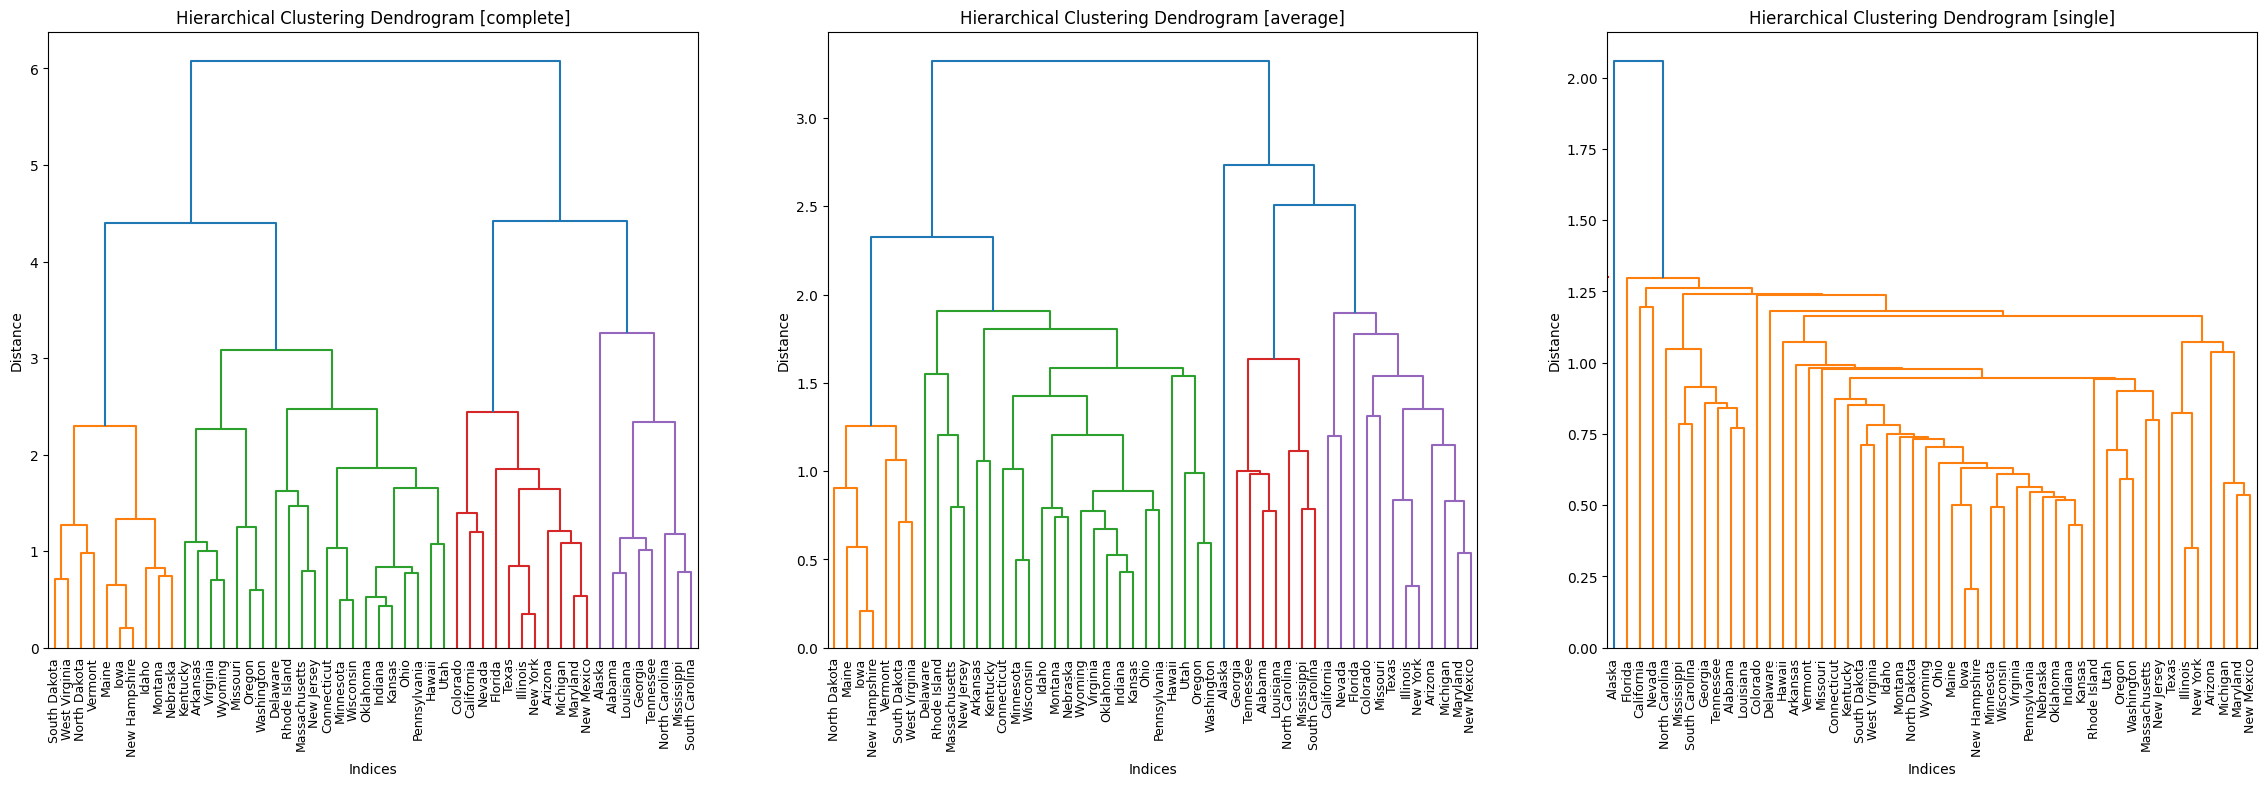

In [5]:
from scipy.cluster import hierarchy as hy
#methods = ["single", "complete", "average", "weighted", "centroid", "median"]
links = ['complete', 'average', 'single']
clust_cuts = [[3.5], [2], [1.3]]
fig, ax = plt.subplots(nrows=1, ncols=len(links), figsize=(28.5,8))

k = len(arrests.index)
for i, l in enumerate(links):
  hc = hy.linkage(arrests, method=l)
  ax[i].set_title(f'Hierarchical Clustering Dendrogram [%s]'%l)
  ax[i].set_ylabel('Distance'); ax[i].set_xlabel('Indices')
  ax[i].hlines(clust_cuts[i], xmin=0, xmax=1, color='red')
  ax[i].grid(False)
  #leaves = hy.dendrogram(hc, p=k, truncate_mode='lastp', no_plot=True)['leaves']
  hy.dendrogram(hc, ax=ax[i], truncate_mode='lastp', p=k, show_contracted=True, leaf_font_size=9, labels=arrests.index)



#### *Note:*

Lowering the number of clusters reduces the the dendrogram further back to its parent root 

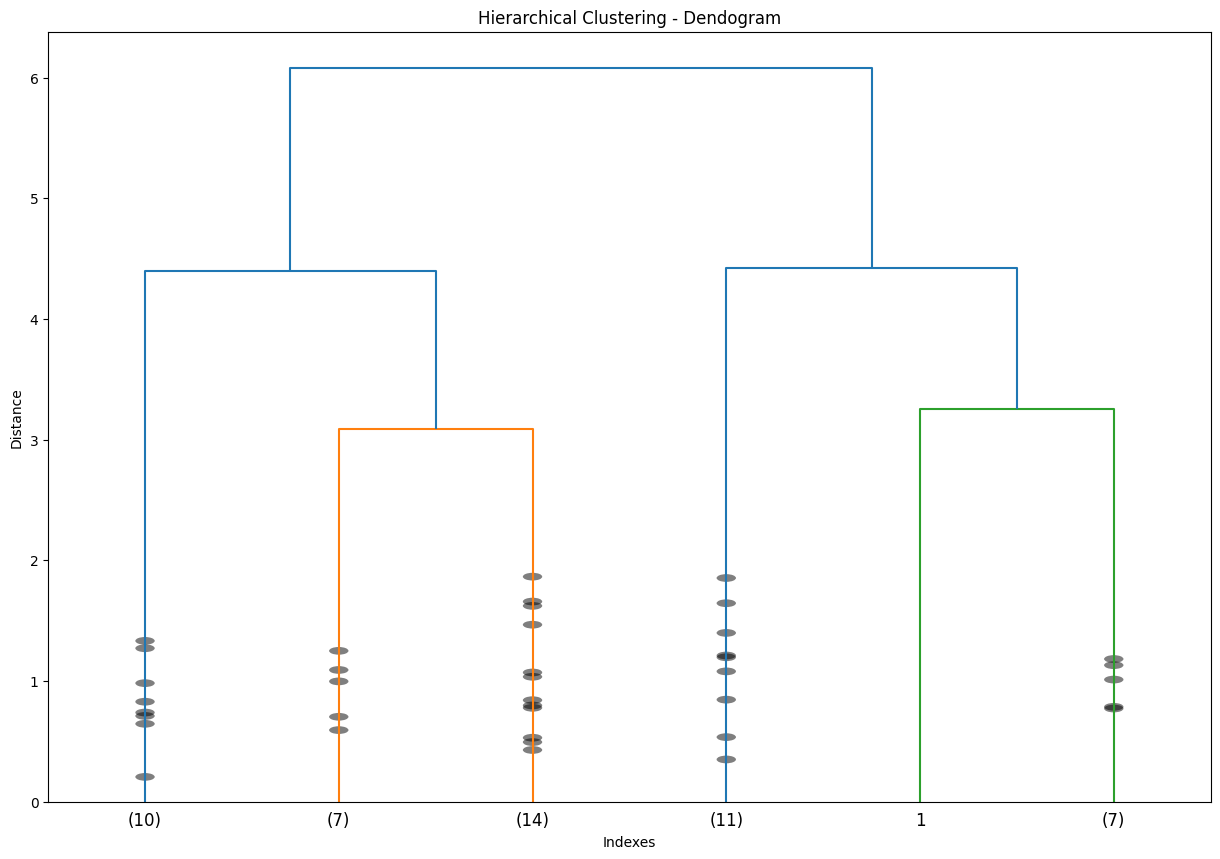

In [6]:
hc = hy.linkage(arrests, method='complete')
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering - Dendogram')
plt.xlabel('Indexes')
plt.ylabel('Distance')
hy.dendrogram(
    hc,
    truncate_mode = "lastp",
    p = 6,
    show_contracted = True);

# KMeans Clustering

## Idea of K-means

+ K-means solves the optimization problem
\begin{equation*}
\underset{\{C_1,\dots,C_K\}\in \mathbf{P}}{\operatorname{argmin}} {\sum_{i=1}^K{L(C_i)}}
\end{equation*}

where $K$ is the number of clusters and $\mathbf{P}$ is the set of all possible observations partitions
+ That is, K-means partitions observations into $K$ clusters such that the total within-cluster variation wrt. the similarity measure is as small as possible
+ The optimization problem defined above is NP-hard, therefore, most of the algorithms only approximate the solution

#### Terminology:
   
- *Centroid* is an average of similar points with continuous features
- *Medoid* is the most representative point in case of categorical features

#### Algorithm:

1. Randomly pick $K$ centroids from the observations as the initial centers of the clusters
2. Loop: 
    - Assign each observation to the nearest centroid
    - Recompute centroids to place them in the center of assigned observations
    - Repeat until the centroids do not change (tolerance) or the maximum number of iterations is reached

#### Properties:

+ The algorithm is guaranteed to decrease the value of objective at due to assignment step and relocation of centroids
+ Performs a local search strategy, similar to hill-climbing algorithm
+ Choice of initial centroids is essential for the performance
+ Important to run the algorithm multiple times with different initial configurations
+ Various algorithms try to select better centroids

### 3 Clusters

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans

KMeans(n_clusters=3)

In [8]:
classes = {
    0 : 'high crime',
    1 : 'in-between',
    2 : 'low crime'
}

km = kmeans.fit(arrests)
km_labels = [classes[i] for i in km.labels_] 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
km_labels[:10]

['in-between',
 'in-between',
 'in-between',
 'low crime',
 'in-between',
 'in-between',
 'high crime',
 'high crime',
 'in-between',
 'in-between']

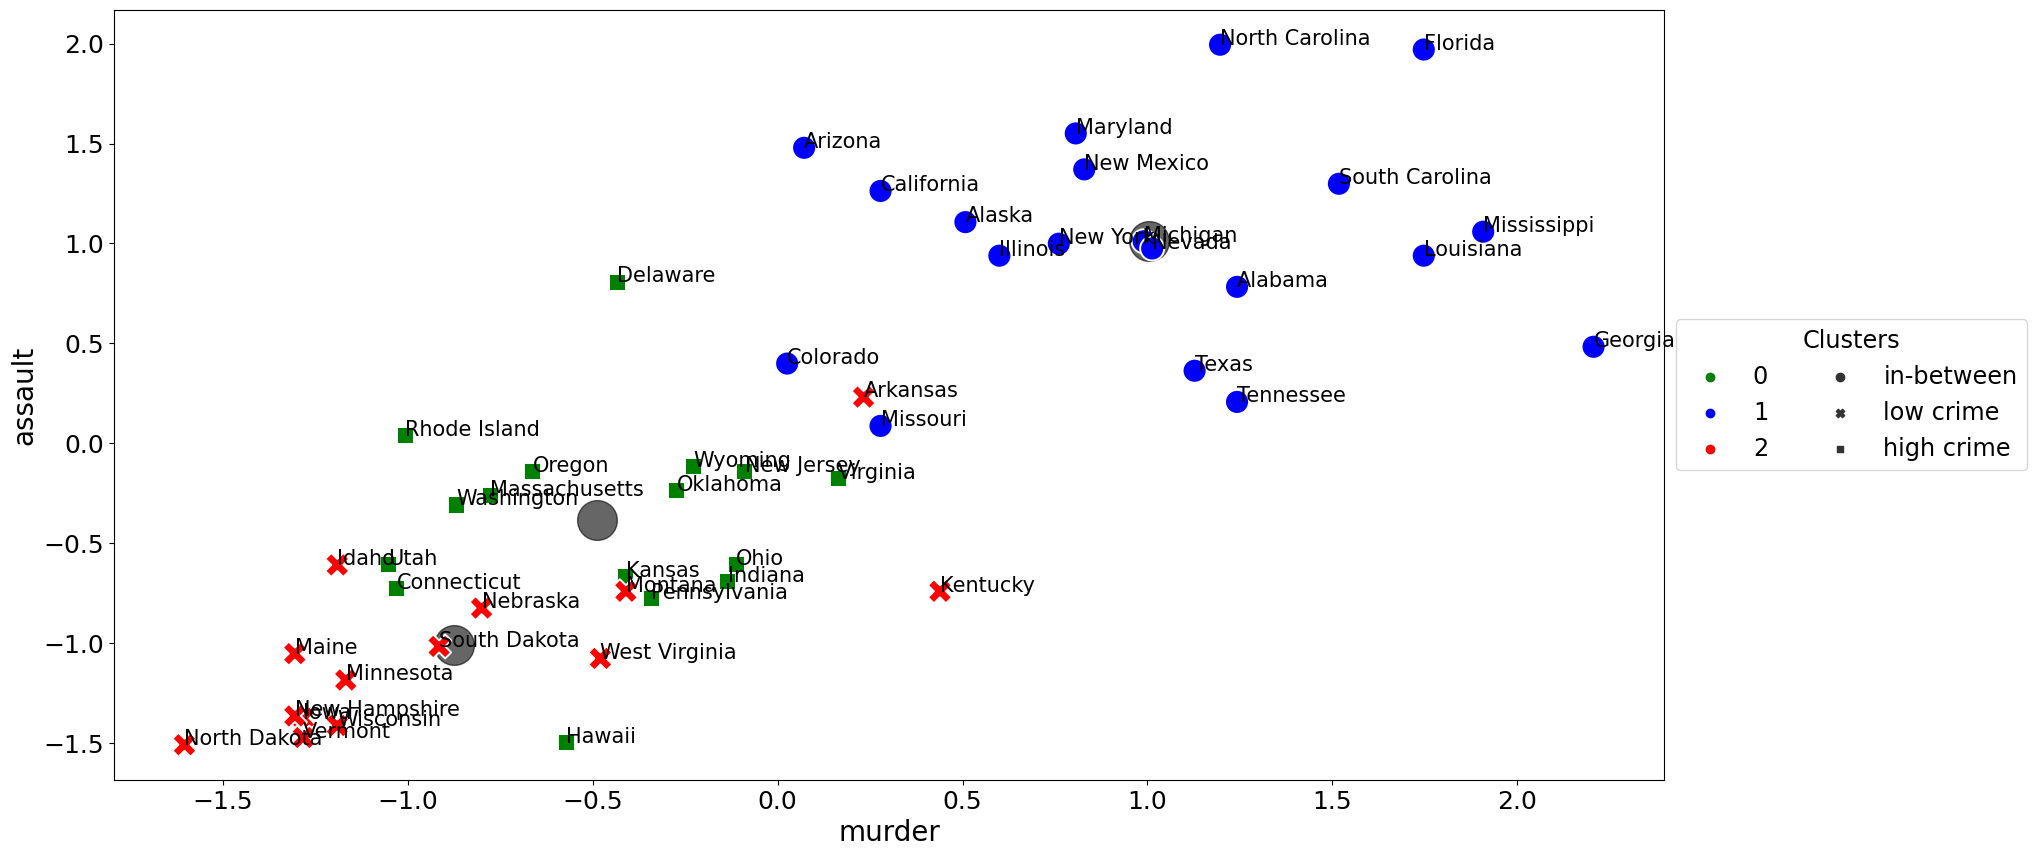

In [10]:
clusters = km.labels_
#plt.scatter(arrests.iloc[:,0], arrests.iloc[:,1], c = clusters,s = 150, cmap="viridis");
centers = km.cluster_centers_

plt.figure(figsize=(20,10))
plt.scatter(centers[:,0], centers[:,1], c="black", s=820, alpha=0.6)


g = sns.scatterplot(x=arrests.iloc[:,0], y=arrests.iloc[:,1], hue=clusters, s=300, style=km_labels,
                 palette=sns.color_palette(['green', 'blue', 'red']))

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title='Clusters', 
         title_fontsize='xx-large', fontsize='xx-large');

for i, txt in enumerate(arrests.index):
    g.text(arrests.iloc[i,0], arrests.iloc[i,1], txt, color='black', size=15)

plt.xlabel('murder', size=20); plt.ylabel('assault', size=20)
plt.xticks(size=18); plt.yticks(size=18); plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


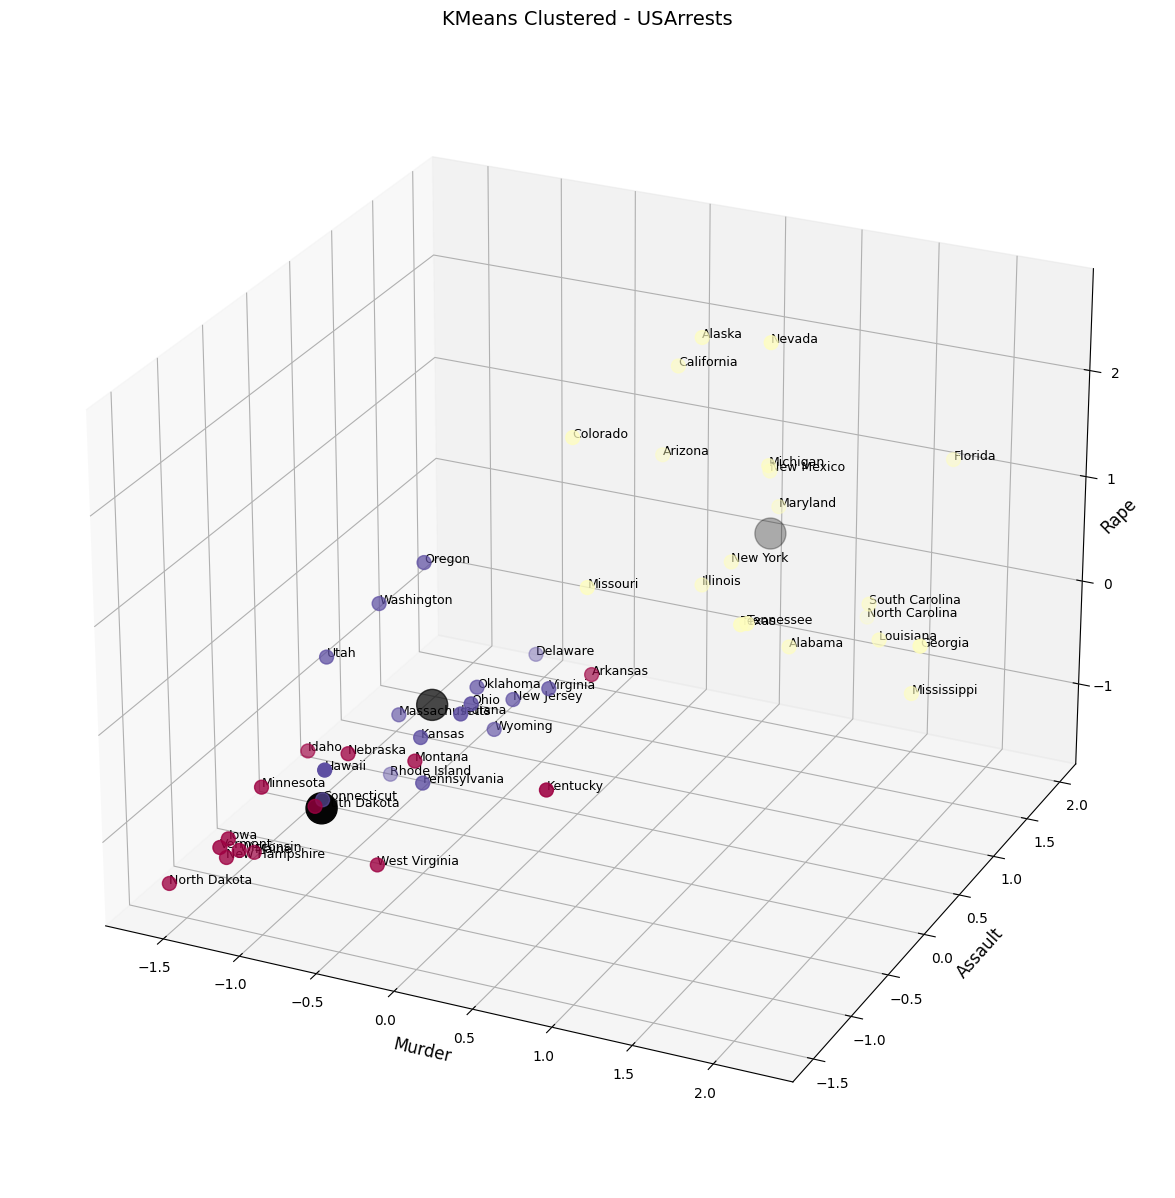

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import signal


sz = 12

plt.rcParams["figure.figsize"] = (28,15)
kmeans = KMeans(n_clusters=3)
km = kmeans.fit(arrests)
clusters = km.labels_
centers = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# adding the individual states to their correspondig scatter observation
for i, txt in enumerate(arrests.index):
    ax.text(arrests.iloc[i,0], arrests.iloc[i,1], arrests.iloc[i,3], txt, color='black', size=9)

# adding padding to the z-axis such that it not pushed away
ax.zaxis.labelpad = -5
ax.scatter(arrests.iloc[:,0], arrests.iloc[:,1], arrests.iloc[:,3], c=clusters, s=100, cmap = 'Spectral_r')#cmap="viridis");
ax.scatter(centers[:,0], centers[:,1], centers[:,3], marker="o", c="#050505", s=500)
ax.set_xlabel('%s' %arrests.columns[0], size = sz)
ax.set_ylabel('%s' %arrests.columns[1], size = sz)
ax.set_zlabel('%s' %arrests.columns[3], size = sz, rotation=45)
ax.set_title('KMeans Clustered - USArrests', size=14)

ax.view_init(azim=-65, elev=25)


# changin viewing angle
x = False
#x = True
while x:
  rotation = int(input('Enter an integer rotation around z-axix (0°-360°): ' ))
  elevation = int(input('Enter an integer elevation (0°-360°: '))

  try:
    ax.view_init(azim=rotation, elev=elevation)

  # default : ax.view_init(azim=-65, elev=30)
  except ValueError:
    print('Wrong Value! Try again by running the cell!')
    ax.view_init(azim=-65, elev=30)
    break

  finally:
    again = input('Would you like to try again? (Y|N): ').upper()
    if again == 'Y':
      continue
    else:
      x = False

plt.show()

### 2 Clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-12-4bf288a96f8b>:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.scatterplot(x=arrests.iloc[:,0], y=arrests.iloc[:,1], hue=clusters, s=300, style=km_labels,


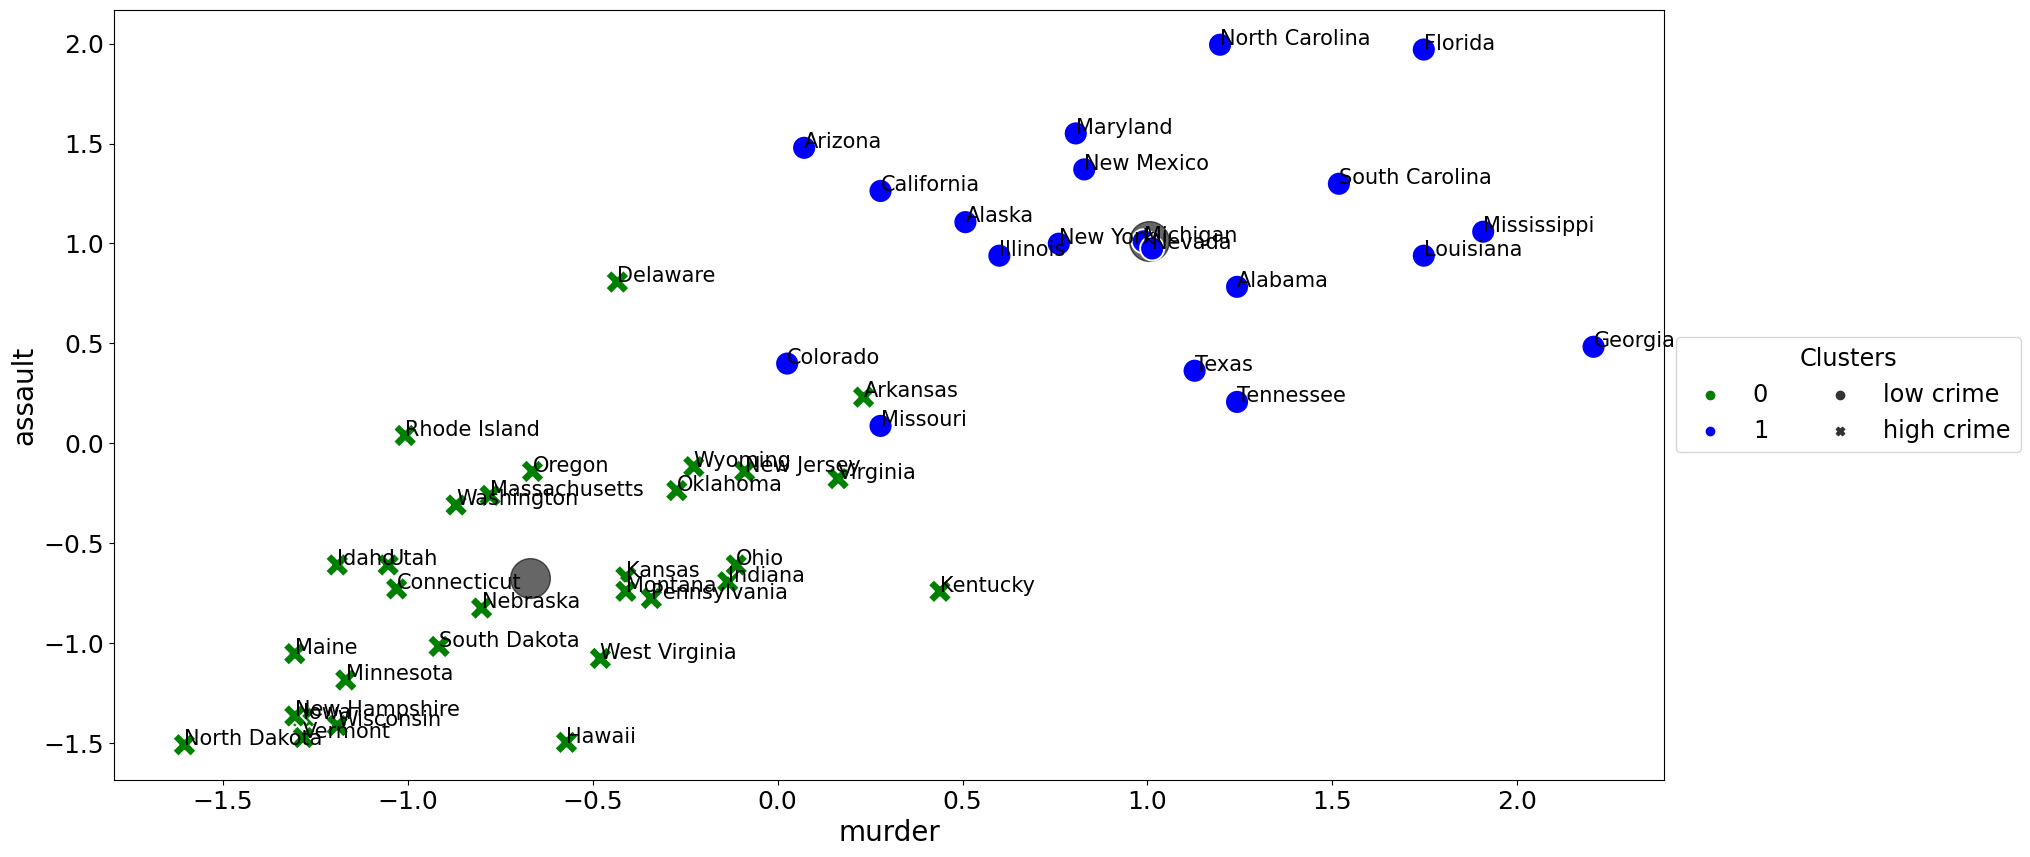

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


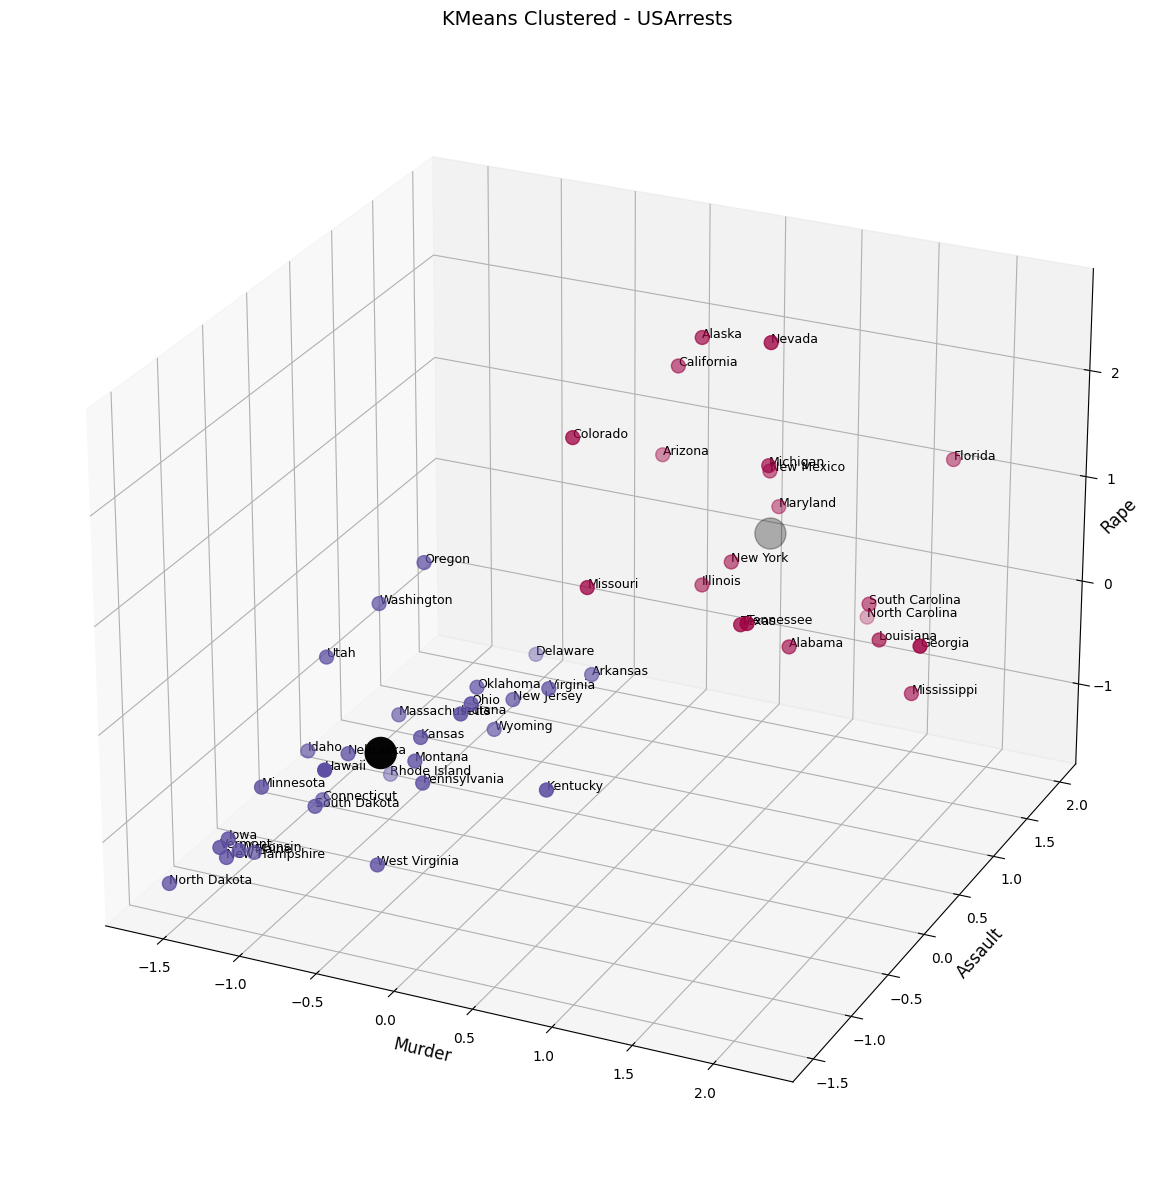

In [12]:
kmeans = KMeans(n_clusters = 2, init='k-means++')
classes = {
    0 : 'high crime',
    1 : 'low crime'
}

# 2d-plot
km = kmeans.fit(arrests)
km_labels = [classes[i] for i in km.labels_] 

clusters = km.labels_
centers = km.cluster_centers_

plt.figure(figsize=(20,10))
plt.scatter(centers[:,0], centers[:,1], c="black", s=820, alpha=0.6)

g = sns.scatterplot(x=arrests.iloc[:,0], y=arrests.iloc[:,1], hue=clusters, s=300, style=km_labels,
                 palette=sns.color_palette(['green', 'blue', 'red']))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title='Clusters', 
         title_fontsize='xx-large', fontsize='xx-large');
for i, txt in enumerate(arrests.index):
    g.text(arrests.iloc[i,0], arrests.iloc[i,1], txt, color='black', size=15)
plt.xlabel('murder', size=20); plt.ylabel('assault', size=20)
plt.xticks(size=18); plt.yticks(size=18); plt.show()

# 3d-plot
sz = 12
plt.rcParams["figure.figsize"] = (28,15)
kmeans = KMeans(n_clusters=2)
km = kmeans.fit(arrests)
clusters = km.labels_
centers = kmeans.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, txt in enumerate(arrests.index):
    ax.text(arrests.iloc[i,0], arrests.iloc[i,1], arrests.iloc[i,3], txt, color='black', size=9)
ax.zaxis.labelpad = -5
ax.scatter(arrests.iloc[:,0], arrests.iloc[:,1], arrests.iloc[:,3], c=clusters, s=100, cmap = 'Spectral_r')#cmap="viridis");
ax.scatter(centers[:,0], centers[:,1], centers[:,3], marker="o", c="#050505", s=500)
ax.set_xlabel('%s' %arrests.columns[0], size = sz)
ax.set_ylabel('%s' %arrests.columns[1], size = sz)
ax.set_zlabel('%s' %arrests.columns[3], size = sz, rotation=45)
ax.set_title('KMeans Clustered - USArrests', size=14)

ax.view_init(azim=-65, elev=25)

plt.show()

# Principal Component Analysis (PCA) - Dimensionality Reduction
### Principal Components:
+ Given an $n \times p$ matrix $\vec{X}$ of observations of $p$ random variables
+ Principal component $\vec{z}_i$ is a normalized linear combination, where last condition is the normalization requirement

\begin{equation*}
\vec{z}_i=\phi_{1i}\vec{x}_1+\dots+\phi_{pi}\vec{x}_p \text{ such that } \sum_{1\leq j \leq p} \phi_{ji}^2=1
\end{equation*}

+ Vector $\vec{\phi}_i=[\phi_{1i},\dots,\phi_{pi}]^\top$ is called a *principal direction* or *axis* of a principal component $\vec{z}_i$
+ Geometrically, the axis $\vec{\phi}_1$ of the first component $\vec{z}_1$ defines a direction in which the data vary the most, and so on
+ Normalization constraint is required, since otherwise these values can be arbitrary large
+ Values $z_{1i}, \dots, z_{ni} \in \vec{z}_i$ are called *scores* of the principal component $\vec{z}_i$

### Computation

+ *Goal*: find a sequence of principal components that have **maximal variance** and are **mutually uncorrelated**
+ Computation of the first principal component corresponds to the optimization problem
\begin{equation*}
\max_{\phi_{11},\dots,\phi_{p1}} \frac{1}{n}\sum_{i=1}^n{z_{i1}^2} \text{ subject to } \sum_{1\leq j \leq p} \phi_{j1}^2=1
\end{equation*}
where $z_{i1}=\phi_{1i}x_1+\dots+\phi_{pi}x_p$
    + That is, we maximize the sample variance of the scores $z_{i1}$ for $1\leq i \leq n$ 
    + This optimization problem is usually solved using the *singular value decomposition* of the matrix $\vec{X}$ 

### Computation details

+ The PCA optimization problem is solved using the eigenvector decomposition of the covariance matrix $\vec{C}$ defined as $$\vec{C}=\frac{\vec{X}^\top\vec{X}}{(n-1)}$$ where $\vec{X}$ is a *centered* $n\times m$ matrix of observations
+ Eigenvalue decomposition of $\vec{C}=\vec{V}\vec{\Lambda}\vec{V}^\top$
   - $\vec{V}$ is a matrix of eigenvectors corresponding to principle directions (axes)
   - Projection of data on these axes $\vec{X}\vec{V}$ gives principal components (scores)
   - $\vec{\Lambda}$ indicate the amount of variance explained
+ Solution with SVD of $\vec{X}=\vec{U}\vec{D}\vec{V}^\top$
    $$ \vec{C} = \frac{1}{n-1}\vec{V}\vec{D}\vec{U}^\top \vec{U}\vec{D}\vec{V}^\top   = \vec{V}\frac{\vec{D}^2}{n-1}\vec{V}^\top$$
  + $\vec{U}^\top \vec{U} = \vec{I}$ because $\vec{U}$ is orthogonal by the definition of the decomposition
  + $\Rightarrow$ columns in $\vec{V}$ are principal directions (eigenvectors of the covariance matrix)
  + $\Rightarrow$ projection of data on these directions $\vec{X}\vec{V} = \vec{U}\vec{D}\vec{V}^\top\vec{V}=\vec{U}\vec{D}$ gives us the scores of the components
  + $\Rightarrow$ loadings - directions $\vec{V}$ scaled by square roots of eigenvalues $\vec{\Lambda}$ of the covariance matrix - are given by columns of 
  $${\vec{V}\frac{\vec{D}}{\sqrt{n-1}}} ~~~~\text{since} ~~~~\vec{\Lambda} = \frac{\vec{D}^2}{n-1}$$

### Loading vectors

+ A *loading vector* is a principal direction scaled by the square root of the variance of the original variable it explains 
    + The green arrow shows the direction of the first component and the orange one -- of the second
    + Length of the vectors - proportion of the variance explained

In [13]:
def std_PCA(df, k=2): 

  X = torch.tensor(df.values, dtype=torch.float32)
  n = X.size()[0]
  if (k > X.size()[1]) : 
      raise ValueError('k must be smaller or equal to {}'.format(X.size()[1]))

  u, d, v = torch.svd(X)
  d = torch.diag(d)
  comps = v[:,:k].t()
  var_exp = torch.matmul(d,d)/(n-1)
  scores =  torch.matmul(u,d)[:,:k]
  loadings = torch.matmul(v, torch.sqrt(var_exp))
  return (scores, comps, torch.diag(var_exp)[:k], loadings[:k].t())

In [14]:
sc_f, cs_f, ve_f, l_f = std_PCA(standardize(arrests), k=4)

tensor(0.6231)


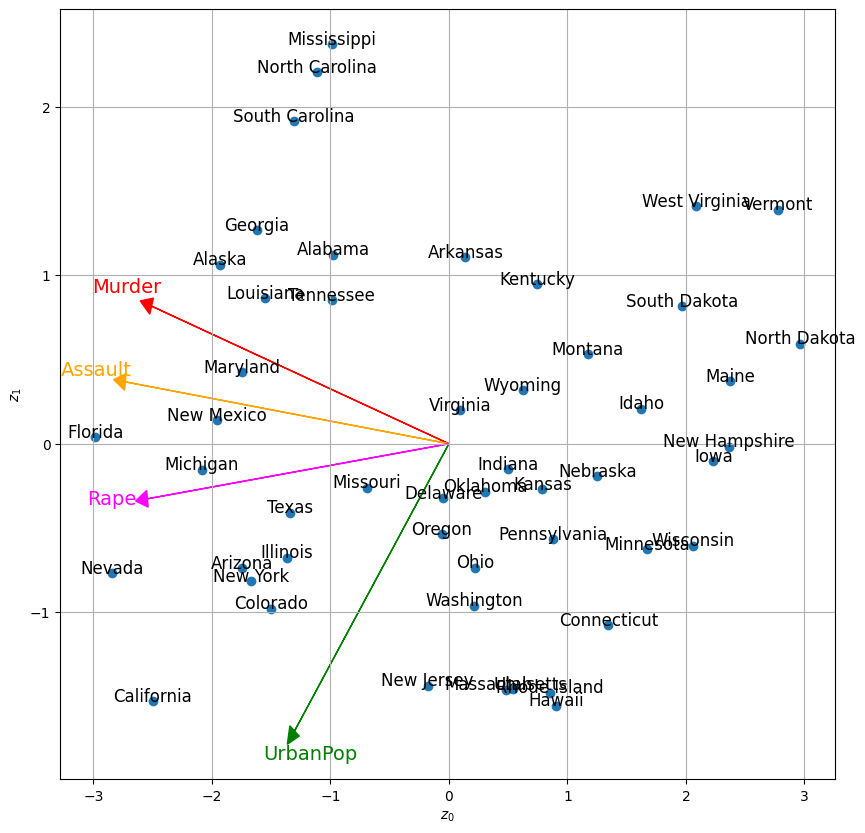

In [15]:
def biplot(z1, z2, sc, comps, obs, features, colors):
    x, y = sc[:,z1], sc[:,z2]
    
    fig = plt.figure(figsize=(10,10))
    plt.xlabel("$z_{}$".format(z1))
    plt.ylabel("$z_{}$".format(z2))

    sx = (x.max() - x.min())/2
    sy = (y.max() - y.min())/2

    plt.scatter(x,y)
    for i in range(len(obs)):
        plt.text(x[i], y[i], obs[i], ha='center', fontsize=12)

    vec = np.transpose(comps[[z1,z2], :])
    print(x[i])
    
    for i in range(len(vec)):
        plt.arrow(0, 0, vec[i,0]*sx, vec[i,1]*sy, ec=colors[i],
                  head_width=0.1, head_length=0.1, fc=colors[i])
        plt.text(vec[i,0]*sx*1.2, vec[i,1]*sy*1.1, features[i], 
                 color = colors[i], fontsize=14)

    plt.grid()

z1, z2 = 0, 1
biplot(z1, z2, sc_f, l_f, arrests.index, arrests.columns, colors=['red', 'orange', 'green', 'magenta'])

# DBSCAN


## Idea behind DBSCAN
+ Classify observations based on their density in the feature space
+ Makes no assumption on a shape of clusters
+ DBSCAN assigns a label to each observation as follows:
    - **Core point**: at least a specified number of points *MinPts* are within the specified radius ϵ
    - **Border point**: an observation that has fewer observations in the radius ϵ than *MinPts*, but is in the radius of a core point
    - **Noise point**: all other points
    - **epsilon ϵ**: neighborhood (threshold density) 
#### Algorithm

1. Create a separate cluster for every set of core points such that every point of this set is in the $\epsilon$ radius of other core points of the same set
2. Assign each border element to a cluster, where its core point is

- Possible disadvantages:
    + High number of features w.r.t. the number of observations might result in reduction of performance
    + Selection of hyperparameters *MinPts* and $\epsilon$ can be problematic
- Spectral clustering methods: use PCA-like approach and focus on spectrum (eigenvalues) of the similarity matrix, to perform dimensionality reduction prior to clustering

<ipython-input-21-9facf291ab91>:18: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  g = sns.scatterplot(x=X[:,0], y=X[:,2], hue=db_labs, s=60, style=db_labs,
<ipython-input-21-9facf291ab91>:18: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  g = sns.scatterplot(x=X[:,0], y=X[:,2], hue=db_labs, s=60, style=db_labs,


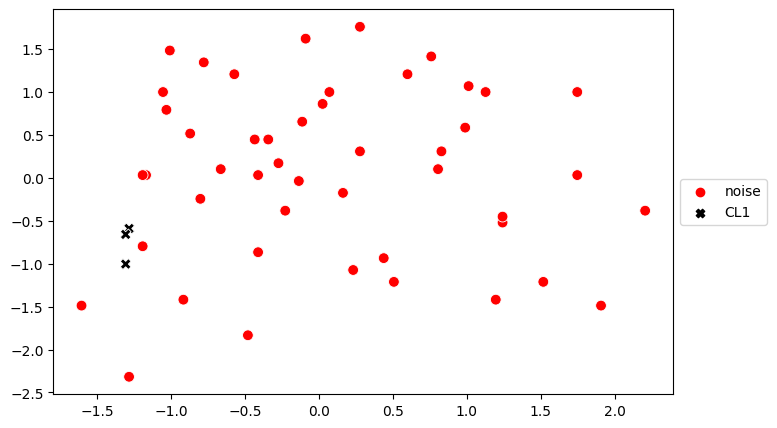

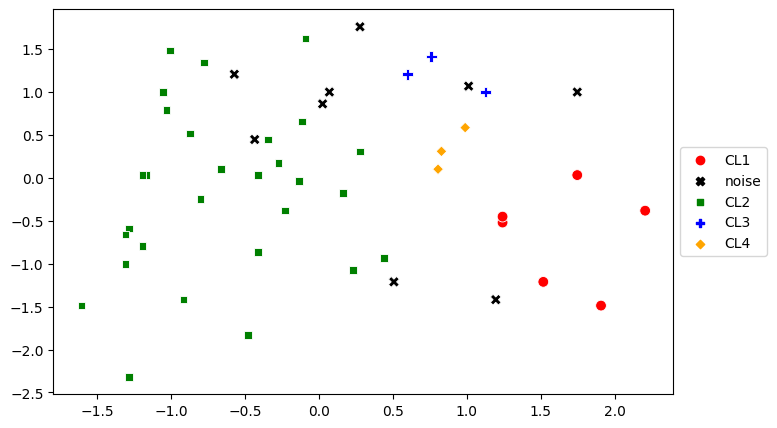

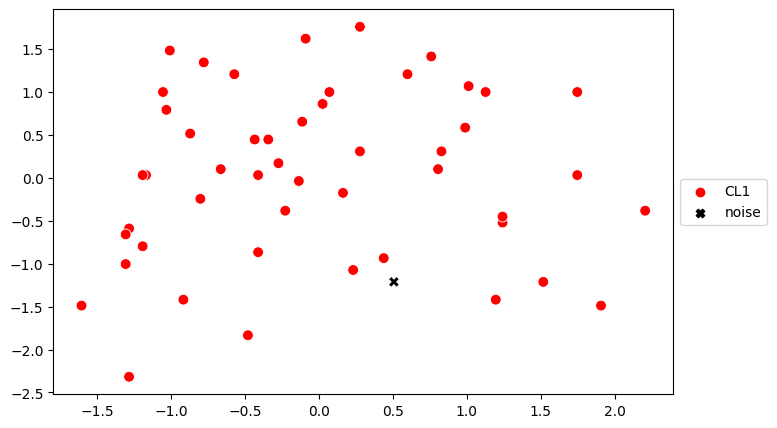

In [21]:
from sklearn.cluster import DBSCAN

epsilons = [0.5, 1, 1.5]

for epsilon in epsilons:
  # arrests is still standardized
  X = arrests.to_numpy()
  classes = {-1 : 'noise',
            0 : 'CL1',
            1 : 'CL2',
            2 : 'CL3',
            3 : 'CL4'}
  db = DBSCAN(eps=epsilon, min_samples=3).fit(X)

  db_labs = [classes[i] for i in db.labels_] 

  plt.figure(figsize=(8, 5))
  g = sns.scatterplot(x=X[:,0], y=X[:,2], hue=db_labs, s=60, style=db_labs,
                  palette=sns.color_palette(['red', 'black', 'green', 'blue', 'orange']))
  g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

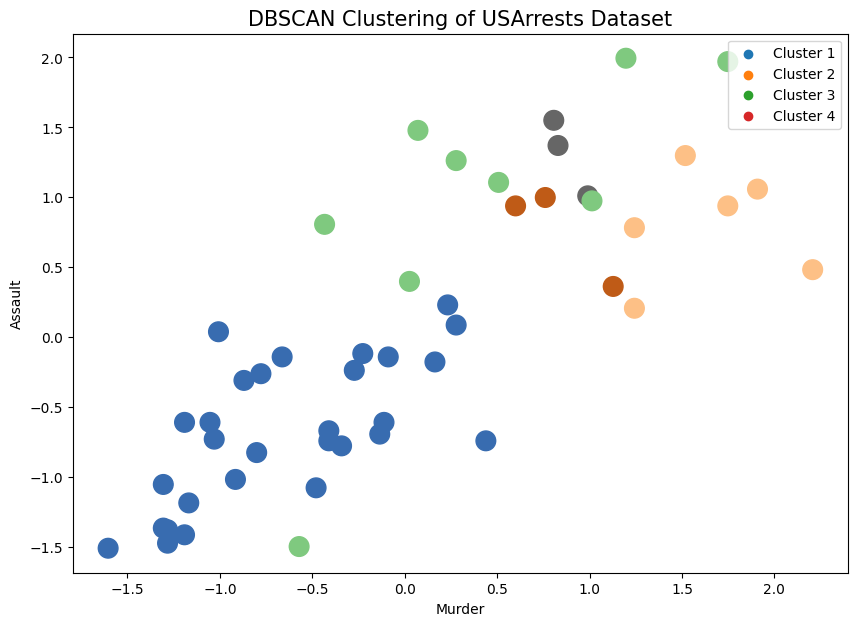

In [25]:
X = arrests.to_numpy()

classes = {-1 : 'noise',
            0 : 'CL1',
            1 : 'CL2',
            2 : 'CL3',
            3 : 'CL4'}

db = DBSCAN(eps=1, min_samples=3).fit(X)

db_labs = [classes[i] for i in db.labels_] 

unique_labels = set(db.labels_)
plt.figure(figsize=(10,7))
for i in unique_labels:
    if i != -1:
        plt.scatter(arrests.iloc[i, 0], arrests.iloc[i, 1], label = 'Cluster {}'.format(i+1))
plt.legend()

plt.scatter(arrests.iloc[:,0], arrests.iloc[:,1], c=db.labels_, cmap='Accent', s=200)
plt.xlabel('Murder')
plt.ylabel('Assault')
plt.title('DBSCAN Clustering of USArrests Dataset', fontsize=15)
#plt.legend(classes[:], loc='center left')
plt.show()

In [26]:
se = pd.read_csv('https://raw.githubusercontent.com/MarkusStefan/Data_Analytics/main/Exercise3/countries_data.csv', delimiter=';')
se.index = se.iloc[:, 0]
se = se.iloc[:, 1::].replace(',', '.', regex=True).astype(float)
# output csv file
#se.to_csv('countries_data.csv', index=True)
se

,population,life_expect,fertility,fertility_adol,mortal_5,mobile_phones,migration,electricity,gdp,inflation,pop_growth,surface_area,unemployment_rate
country,,,,,,,,,,,,,
Afghanistan,38972230.0,62.58,4.75,84.30,57.8,58.19,166821.0,97.70,553.04,5.60,3.13,652860.0,11.71
Albania,2837849.0,76.99,1.40,14.67,9.4,91.35,-9117.0,100.00,4410.46,1.62,-0.57,28750.0,13.07
Algeria,43451666.0,74.45,2.94,12.06,22.9,104.84,-18797.0,99.80,3873.51,2.42,1.73,2381741.0,12.25
Angola,33428486.0,62.26,5.37,139.83,72.1,43.81,7557.0,46.89,2347.79,22.27,3.27,1246700.0,10.35
Argentina,45376763.0,75.89,1.91,39.87,7.7,121.60,2344.0,100.00,11341.27,42.02,0.97,2780400.0,11.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vanuatu,311685.0,70.30,3.78,64.86,24.0,79.00,-197.0,67.33,2623.05,5.33,2.36,12190.0,2.02
Vietnam,96648685.0,75.38,1.96,34.71,20.9,143.75,-2016.0,100.00,3352.06,3.22,0.91,331340.0,2.10
West Bank and Gaza,4803269.0,74.40,3.57,44.53,15.3,79.63,-12369.0,100.00,2922.47,-0.74,2.49,6020.0,25.89


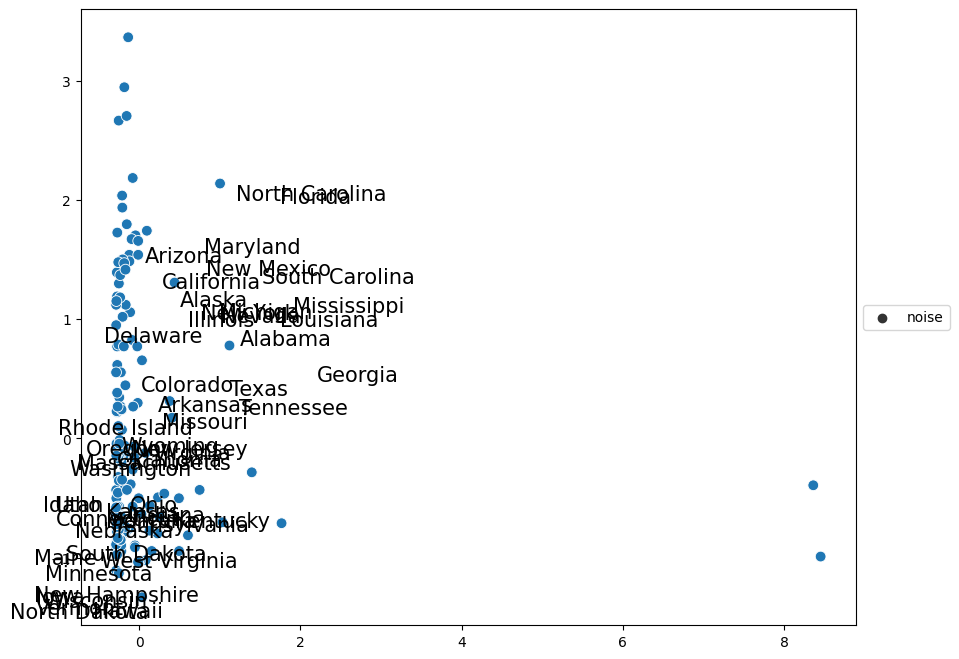

In [32]:
se = standardize(se)
X = se.to_numpy()
classes={-1: 'noise', 0 : 'setosa', 1 : 'versicolor', 2 : 'virginica', 3:'unknown'}

db = DBSCAN(eps=0.55, metric='euclidean').fit(X)
db_labels = [classes[i] for i in db.labels_] 

plt.figure(figsize=(10, 8))
g = sns.scatterplot(x=X[:,0], y=X[:,2], s=60, style=db_labels)
for i, txt in enumerate(arrests.index):
    g.text(arrests.iloc[i,0], arrests.iloc[i,1], txt, color='black', size=15)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

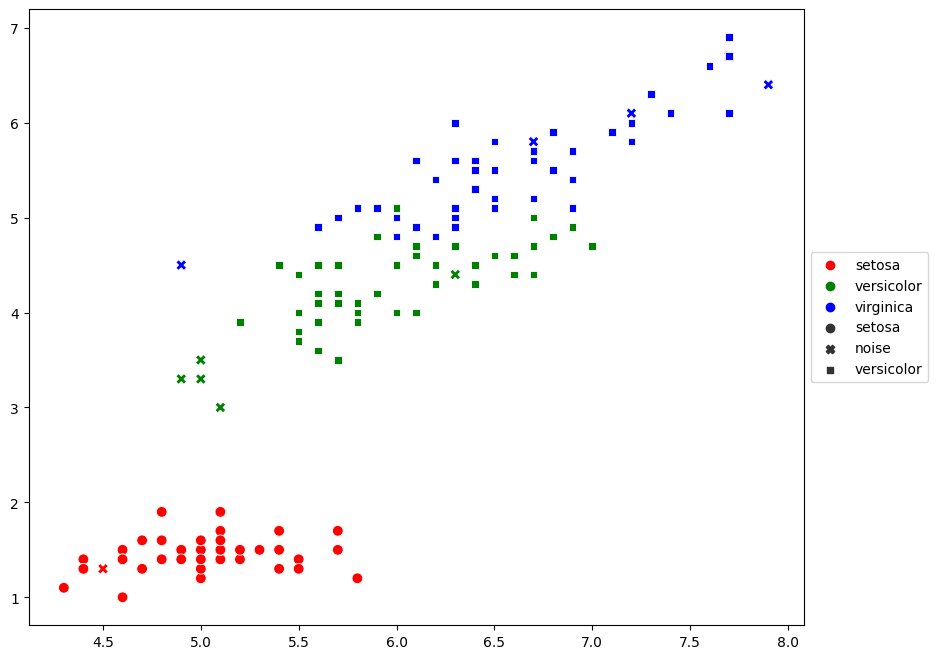

In [28]:
df = sns.load_dataset("iris")
X = df.to_numpy()[:,0:4]
classes={-1: 'noise', 0 : 'setosa', 1 : 'versicolor', 2 : 'virginica', 3:'unknown'}

db = DBSCAN(eps=0.55, metric='euclidean').fit(X)
db_labels = [classes[i] for i in db.labels_] 

plt.figure(figsize=(10, 8))
g = sns.scatterplot(x=X[:,0], y=X[:,2], hue=df['species'], s=60, style=db_labels,
                palette=sns.color_palette(['red', 'green', 'blue']))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);